# Quantitative Analysis of Price & Daily Returns
* Can returns be described with a normal distribution?
* Is daily change non-zero?
* Can price movement be described as a random walk?

### 1. Set up environment 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6
import seaborn as sb
sb.set()
import pandas_datareader as pdr

### 2.  Download stock price data, store in dataframe

In [2]:
# default parameters gives 5 years of data
amzn = pdr.get_data_yahoo('AMZN')

### 3. Take a look at the data

In [3]:
amzn.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-04,759.679993,754.200012,758.390015,757.179993,2510500,757.179993
2017-01-05,782.400024,760.260010,761.549988,780.450012,5830100,780.450012
2017-01-06,799.440002,778.479980,782.359985,795.989990,5986200,795.989990
2017-01-09,801.770020,791.770020,798.000000,796.919983,3446100,796.919983
2017-01-10,798.000000,789.539978,796.599976,795.900024,2558400,795.900024


### 4. Store instantaneous rate of return in separate series

In [4]:
amzn_close = amzn['Close']
amzn_return = round(np.log(amzn.Close).diff() * 100, 2)
amzn_return.dropna(inplace = True)
amzn_return.head()

Date
2017-01-05    3.03
2017-01-06    1.97
2017-01-09    0.12
2017-01-10   -0.13
2017-01-11    0.39
Name: Close, dtype: float64

### 5. Plot the series 

<AxesSubplot:xlabel='Date'>

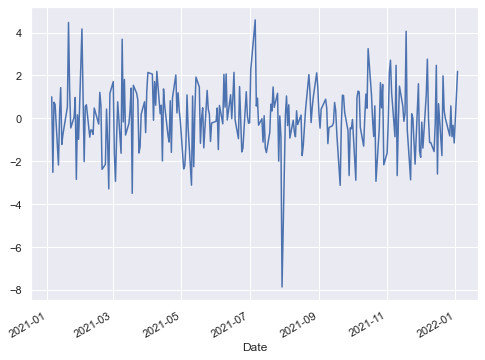

In [5]:
amzn_return[-252:].plot()

### 6. Pandas describe function gives descriptive statistics, default assumes you are dealing with a sample Pandas also deals with missing values by omitting them 

In [6]:
amzn_return.dropna(inplace=True)
amzn_return.describe()

count    1258.00000
mean        0.11961
std         1.85037
min        -8.25000
25%        -0.73000
50%         0.14500
75%         1.06000
max        12.41000
Name: Close, dtype: float64

### 7. An alternative more slightly  different table of descriptives from scipy stats

In [7]:
from scipy import stats

In [8]:
n, minmax, mean, var, skew, kurt = stats.describe(amzn_return)
mini, maxi = minmax
std = var ** .5

### 9. for comparision generate random numbers that follow normal distribution


In [9]:
from scipy.stats import norm

In [10]:
x = norm.rvs(mean, std, n)

In [11]:
stats.describe(x)

DescribeResult(nobs=1258, minmax=(-7.117133992171511, 6.166657735133353), mean=0.18883899641395016, variance=3.5720158065065006, skewness=-0.08844443822505323, kurtosis=0.028919619818789766)

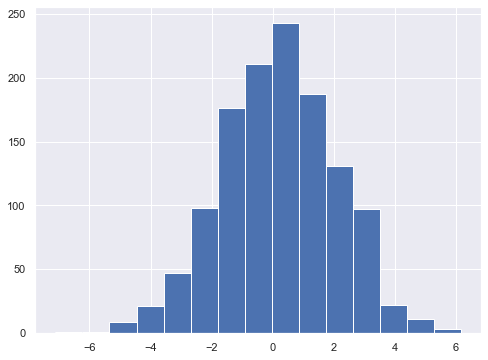

In [12]:
plt.hist(x, bins=15);

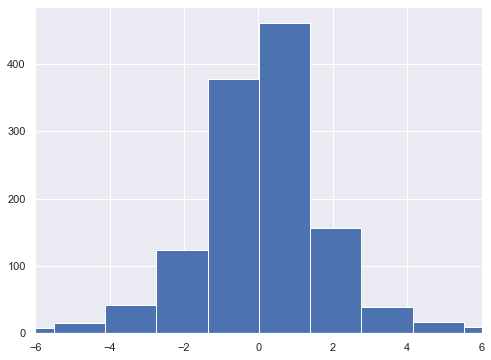

In [13]:
plt.hist(amzn_return, bins = 15)
plt.xlim(-6,6);

## Is price change normally distributed?

### 10. Use scipy stats to test the kurtosis, the null hypothesis is that the sample is drawn from a population where the underlying kurtosis is that of a normally distributed variable

In [14]:
x_test = stats.kurtosistest(x)
amzn_test = stats.kurtosistest(amzn_return)
print(f'{"     Test statistic":20}{"p-value":>15}')
print(f'{" "*5}{"-"* 30}')
print(f"x:{x_test[0]:>17.2f}{x_test[1]:16.4f}")
print(f"AMZN: {amzn_test[0]:13.2f}{amzn_test[1]:16.4f}")

     Test statistic         p-value
     ------------------------------
x:             0.31          0.7564
AMZN:         11.38          0.0000


### 11. plot histogram of price changes with normal curve overlay


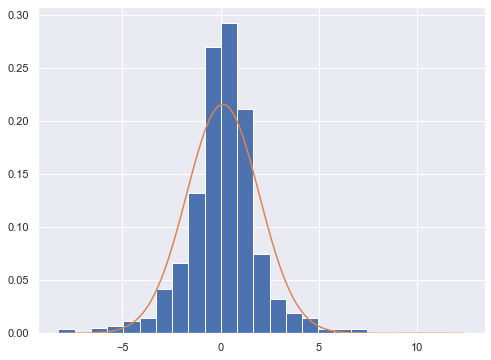

In [15]:
plt.hist(amzn_return, bins = 25, edgecolor='w', density= True)
data = np.linspace(mini, maxi, 100)
plt.plot(data, norm.pdf(data, mean, std));

### 12. Compare normally distributed sample with same attributes as amzn price change

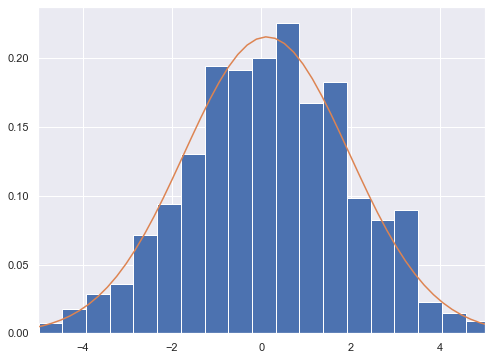

In [16]:
plt.hist(x, bins =25, density = True)
b = np.linspace(mini, maxi, 100)
plt.plot(b,stats.norm.pdf(b, mean, std))
plt.xlim(-5,5);

## Is daily price change significantly different from zero?

### 13. Conduct simple hypothesis test

In [17]:
stats.ttest_1samp(amzn_return.sample(252), 0, alternative='two-sided')

Ttest_1sampResult(statistic=1.165219103569798, pvalue=0.2450364692324925)

## Can price movement be described as a random walk?

### 14. Create price lags

In [23]:
amzn_close = pd.DataFrame(amzn.Close, columns= ['Close'])
amzn_close['lag_1'] = amzn_close.Close.shift(1)
amzn_close['lag_2'] = amzn_close.Close.shift(2)
amzn_close.dropna(inplace = True)
amzn_close.head()

,Close,lag_1,lag_2
Date,,,
2017-01-06,795.989990,780.450012,757.179993
2017-01-09,796.919983,795.989990,780.450012
2017-01-10,795.900024,796.919983,795.989990
2017-01-11,799.020020,795.900024,796.919983
2017-01-12,813.640015,799.020020,795.900024


### 15. Fit linear model

In [25]:
lr = np.linalg.lstsq(amzn_close[['lag_1', 'lag_2']], amzn_close.Close, rcond=None)[0]

In [26]:
amzn_close['predict'] = np.dot(amzn_close[['lag_1', 'lag_2']], lr)

In [27]:
amzn_close.head()

,Close,lag_1,lag_2,predict
Date,,,,
2017-01-06,795.989990,780.450012,757.179993,780.275654
2017-01-09,796.919983,795.989990,780.450012,796.069352
2017-01-10,795.900024,796.919983,795.989990,797.458617
2017-01-11,799.020020,795.900024,796.919983,796.499142
2017-01-12,813.640015,799.020020,795.900024,799.491406


<AxesSubplot:xlabel='Date'>

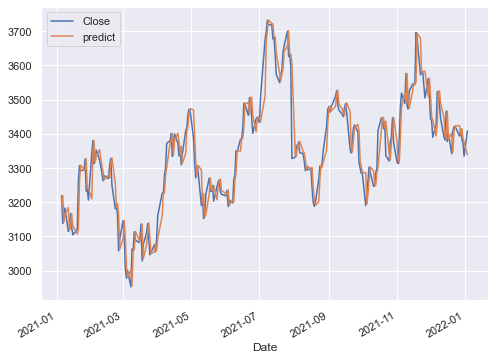

In [28]:
amzn_close.iloc[-252:][['Close', 'predict']].plot()